# Privacy - attack model - part1 : Wasserstein GAN

__Main goal__ : the main goal of this part is to use public data to build a generator able to produce the kind of output we want to reveal. Here we want to reveal images of hand written digits from 0 to 4. We use images of hand written digits from 5 to 9 to train the generator, so that the public and private dataset do not overlap.

__Reference for the WGAN__ : 
* https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
* https://github.com/ilguyi/gans.tensorflow.v2/blob/master/tf.v2/01.dcgan.ipynb

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys
assert sys.version_info >= (3, 5)
import pandas as pd
import numpy as np 
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)

from IPython import display
from tqdm import tqdm

import time
from datetime import datetime

###########
## plots ##
###########

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

######
# TF #
######
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomNormal
tf.__version__

#########
# utils #
#########

os.sys.path.append("./src")
from utils import plot_img
from utils import load_mnist_data

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
if not "gan" in os.listdir("./model"):
    os.mkdir("model/gan")

# Get the data

In [3]:
def load_dataset(TRAIN_BUF, BATCH_SIZE, TEST_BUF, data_type="public"):
    
    train_images, train_labels, test_images, test_labels = load_mnist_data(data_type)

    train_dataset = (
        tf.data.Dataset.from_tensor_slices(train_images)
        .shuffle(TRAIN_BUF)
        .batch(BATCH_SIZE))

    test_dataset = (
        tf.data.Dataset.from_tensor_slices(test_images)
        .shuffle(TEST_BUF)
        .batch(BATCH_SIZE))

    plot_img(train_images, train_labels)

    return train_dataset, test_dataset

# Create the generator and discriminator

### The generator

In [4]:
def get_generator(latent_dim=64):
    
    init = RandomNormal(stddev=0.02)
    
    generator = Sequential()
    generator.add(InputLayer(input_shape=(1, 1, latent_dim)))
    generator.add(Dense(units=7 * 7 * 64, activation="relu"))
    generator.add(Reshape(target_shape=(7, 7, 64)))
    generator.add(Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2),
                                  kernel_initializer=init, padding="SAME", activation="relu"))
    generator.add(Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2),
                                  kernel_initializer=init, padding="SAME", activation="relu"))
    generator.add(Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1),
                                  kernel_initializer=init, padding="SAME", activation="sigmoid"))
    
    return generator

### The discriminator

In [15]:
def get_discriminator(dims):
    
    discriminator = Sequential()
    discriminator.add(InputLayer(input_shape=dims))
    discriminator.add(Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"))
    discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"))
    discriminator.add(Flatten())
    discriminator.add(Dense(units=1, activation="sigmoid"))
    
    return discriminator

number_of_disc_layers = 6

# Compute the loss and the training loop

### The loss

In [6]:
@tf.function
def compute_loss(train_x):
    
    # Random object in the latent space
    x = tf.random.normal([train_x.shape[0], 1, 1, 64])
    
    # Create real and fake outputs
    real_output = discriminator(train_x)
    fake_output = discriminator(generator(x))
    
    # Compute loss
    disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)
    gen_loss = -tf.reduce_mean(fake_output)

    return disc_loss, gen_loss

### One step of training

In [7]:
@tf.function
def train_step(train_x, generator_optimizer, discriminator_optimizer, n_steps=4):
    x = tf.random.normal([train_x.shape[0], 1, 1, 64])
    for i in range(n_steps):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            # Create true and fake outputs
            real_output = discriminator(train_x)
            fake_output = discriminator(generator(x))
            
            # Compute the loss
            disc_loss = -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)

            # Train the discriminator for each step with gradient descent
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            
            # Clip the weights of the discriminator's layers
            t=0
            for t in range(number_of_disc_layers):
                y = tf.clip_by_value(discriminator.trainable_weights[t],
                                     clip_value_min=-0.05,
                                     clip_value_max=0.05,
                                     name=None)
                discriminator.trainable_weights[t].assign(y)
            
            # Train the generator only for the last step
            if i == (n_steps-1) :
                
                # Create fake image and predict if they are true thank to the discriminator 
                fake_training_data = generator(x)
                fake_output = discriminator(fake_training_data)
                
                # The loss for the generator is the inverse of the mean of fake output
                # The generator goal is to fool the discriminator
                gen_loss = -tf.reduce_mean(fake_output)
                
                # Gradient descent
                gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

# Train

In [8]:
def plot_reconstruction(epoch, train_x, nex=8, zm=2):
    
    samples = generator(tf.random.normal([train_x.shape[0], 1, 1, 64]))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    
    for axi in range(nex):
        axs[axi].matshow(samples.numpy()[axi].squeeze(),
                         cmap=plt.cm.Greys,
                         vmin=0,
                         vmax=1)
        axs[axi].axis('off')
    
    plt.savefig(os.path.join("model","gan",'gan_results_epoch_%03d.png' %(epoch)))
    plt.show()

In [9]:
def train(n_epoch, train_dataset, generator_optimizer, discriminator_optimizer, losses, N_TRAIN_BATCHES, N_TEST_BATCHES):
    start = time.time()
    for epoch in range(n_epochs):

        # train
        for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
            train_step(train_x, generator_optimizer, discriminator_optimizer)

        # test
        loss = []
        for batch, test_x in tqdm(zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
            loss.append(compute_loss(train_x))
        losses.loc[len(losses)] = np.mean(loss, axis=0)

        # plot results
        display.clear_output()
        print("Epoch: {} | disc_loss: {} | gen_loss: {}".format(epoch, 
                                                                losses.disc_loss.values[-1], 
                                                                losses.gen_loss.values[-1]))
        plot_reconstruction(epoch, test_x)

    time_to_train_gan = time.time() - start
    tf.print ('Time for the training is {} sec,'.format( time.time() - start))
    
    return losses

### Settings

In [10]:
def get_optimizers(gen_learning_rate, disc_learning_rate):
    
    # RMSprop optimizer
    generator_optimizer = tf.keras.optimizers.RMSprop(gen_learning_rate)
    discriminator_optimizer = tf.keras.optimizers.RMSprop(disc_learning_rate)
    
    return generator_optimizer, discriminator_optimizer

In [12]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

n_epochs = 150

generator_optimizer, discriminator_optimizer = get_optimizers(gen_learning_rate=0.00003, disc_learning_rate = 0.00005)

losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [16]:
generator = get_generator()
discriminator = get_discriminator(dims=DIMS)

train size : 29404
test size : 4861
total size : 34265


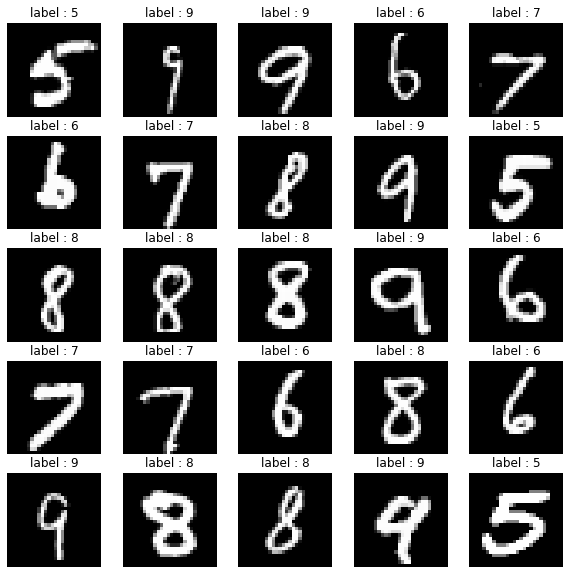

In [17]:
train_dataset, test_dataset = load_dataset(TRAIN_BUF, BATCH_SIZE, TEST_BUF, data_type="public")

Epoch: 149 | disc_loss: 0.056034862995147705 | gen_loss: -0.47417086362838745


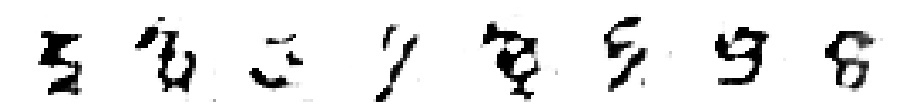

Time for the training is 7327.410750627518 sec,


In [18]:
losses = train(n_epochs, train_dataset, generator_optimizer, discriminator_optimizer, 
               losses, N_TRAIN_BATCHES=N_TRAIN_BATCHES, N_TEST_BATCHES=N_TEST_BATCHES)

In [19]:
t1 = datetime.now().timestamp()
generator_path = os.path.join("model", 'attack_gan_model_%04d.h5' % (t1))
generator.save(generator_path)

In [20]:
discriminator_path = os.path.join("model", 'discriminator_model_%04d.h5' % (t1))
discriminator.save(discriminator_path)

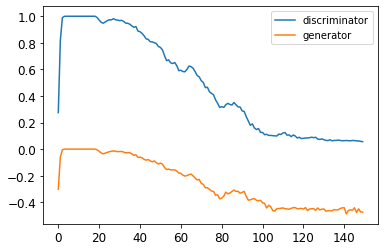

In [21]:
plt.plot(losses)
plt.legend(["discriminator", "generator"])
plt.savefig(os.path.join("model", 'gan_loss_%04d.png') % (t1))
plt.show()

In [22]:
gen_load = load_model(generator_path)

In [23]:
disc_load = load_model(discriminator_path)

In [24]:
gen_load.predict(tf.random.normal([1, 1, 1, 64])).shape

(1, 28, 28, 1)

In [25]:
disc_load.predict(gen_load.predict(tf.random.normal([1, 1, 1, 64])))

array([[0.44626266]], dtype=float32)